In [1]:
from fastai.text.all import *

## Example: positional encoding

$$\textit{PE}_{(pos,2i)} = \sin(pos/10000^{2i/d_{model}})$$

$$\textit{PE}_{(pos,2i+1)} = \cos(pos/10000^{2i/d_{model}})$$

where $pos$ is the position and $i$ is the dimension.

In [2]:
dims = 20
max_len = 100

In [3]:
torch.arange(0., dims, 2.)

tensor([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.])

In [4]:
freq = 1 / (10000 ** (torch.arange(0.0, dims, 2.0)/dims))
freq

tensor([1.0000e+00, 3.9811e-01, 1.5849e-01, 6.3096e-02, 2.5119e-02, 1.0000e-02,
        3.9811e-03, 1.5849e-03, 6.3096e-04, 2.5119e-04])

In [5]:
m = torch.outer(torch.arange(max_len), freq)
m.shape

torch.Size([100, 10])

In [6]:
pos_embs = torch.cat([m.sin(), m.cos()], dim=-1)
pos_embs.shape

torch.Size([100, 20])

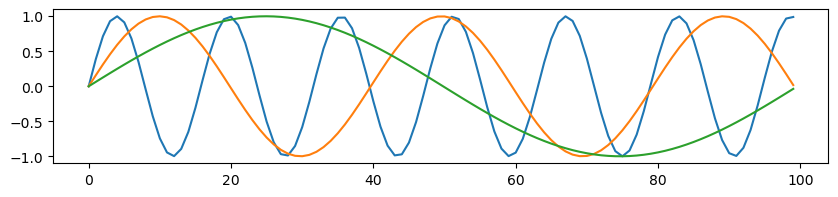

In [7]:
fig,ax = plt.subplots(figsize=(10,2))
# ax.plot(pos_embs[:, 0])
ax.plot(pos_embs[:, 1])
ax.plot(pos_embs[:, 2])
ax.plot(pos_embs[:, 3]);

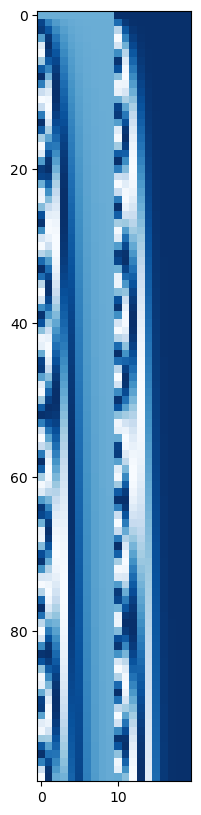

In [8]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(pos_embs, cmap=plt.cm.Blues);

## Data

In [9]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

/home/renato/miniforge3/envs/nl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

(#2) [Path('/home/renato/.fastai/data/imdb_sample/texts.csv'),Path('/home/renato/.fastai/data/imdb_sample/models')]

In [11]:
df = pd.read_csv(path/'texts.csv')
df.sample(3)

,label,text,is_valid
745,negative,"From a plot and movement standpoint, this movie was terrible. I found myself looking at the clock in theater hoping it would end and relieved after 80 long minutes that it mercifully did. Basically, five characters appear in the movie, A Son & Father, son's girl friend, and two male characters of the son's age who appear and then disappear without context or explanation. The movie and scenes seemed to suggest homo-eroticism, but nothing ever actually happened to reveal this one way or another. There were a couple of brilliant scenes. At the beginning of the movie, the son's girl friend sho...",False
381,positive,"""Gunga Din"": one of the greatest adventure stories ever told! A story about the British Foreign legion in 19th century India and a lowly ""water-bearer"" named Gunga Din, a local denizen who aspires to be just like his military counterparts; three British sergeants whose loyalty and camaraderie for each other extend far beyond the bounds of mere patriotism. Their's is a true and abiding friendship for one another and each would be willing to sacrifice his own life for the good of the other. Gunga Din longs to be a soldier too, a Bugler in particular, but can never attain that rank due to his...",False
614,negative,"A below average looking video game is turned into some sort of conspiracy to have the next terrorist discovered in the USA backyard. Welcome to the lunacy of cheaply made direct to video movies. Its full of no-name actors and actresses with little valuable plot.<br /><br />Anyway, this strange game goes on and our ""hero"" bets real money and does good at it. It is sort of like gambling, except the gambling part is gone and it sucks. Instead its an online game with little real value and you get authorities on your tail if you do good.<br /><br />What makes it even stranger is that two strang...",False


In [12]:
ds = Dataset.from_pandas(df).rename_columns({'label':'labels'}).class_encode_column('labels')
ds


asting to class labels: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333516.54 examples/s]

Dataset({
    features: ['labels', 'text', 'is_valid'],
    num_rows: 1000
})

In [13]:
# model_name = 'microsoft/deberta-v3-small'
model_name = 'answerdotai/ModernBERT-base'

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [15]:
sample_text = ds[0]['text'][:50]
sample_text

"Un-bleeping-believable! Meg Ryan doesn't even look"

In [16]:
tokenizer.tokenize(sample_text)

['Un',
 '-',
 'ble',
 'eping',
 '-',
 'belie',
 'vable',
 '!',
 'ĠMeg',
 'ĠRyan',
 'Ġdoesn',
 "'t",
 'Ġeven',
 'Ġlook']

In [17]:
ds_tokenized = ds.map(lambda row: tokenizer(row['text'], truncation=True), batched=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.

ap: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9406.36 examples/s]

In [18]:
ds_tokenized

Dataset({
    features: ['labels', 'text', 'is_valid', 'input_ids', 'attention_mask'],
    num_rows: 1000
})

In [19]:
row = ds_tokenized[0]
print(row['text'], '\n----\n', row['input_ids'])

Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff! 
----
 [50281, 2447, 14, 934, 10413, 14, 21002, 17254, 2, 18694, 13114, 2506, 626, 1014, 1007, 617, 7312, 6925, 6652, 494, 1881, 275, 436, 13, 534, 9403, 2789, 479, 23697, 617, 20126, 7049, 90, 8534, 5807, 47487, 15, 11366, 281, 2868, 703, 369, 253, 14281, 327, 436, 4370, 15, 14820, 15273, 611, 1282, 27, 752, 2238, 273, 13184, 7408, 556, 521, 5249, 644, 327, 32, 8452, 6934, 1051, 378, 11670, 2284, 15844, 6610, 436, 369, 6828, 407, 253, 5599, 665, 858, 7967, 775, 408, 32, 19680, 320, 247, 44864, 273, 10354, 383, 628, 428, 5965, 314, 5308, 3740, 15, 411, 3288, 2727, 71, 2, 50282]


In [20]:
df.text.str.len().describe()

count    1000.000000
mean     1406.072000
std      1046.166506
min       195.000000
25%       723.000000
50%      1040.500000
75%      1742.250000
max      7382.000000
Name: text, dtype: float64

In [21]:
def get_ds(df):
    return (
        Dataset
        .from_pandas(df)
        .rename_columns({'label':'labels'})
        .class_encode_column('labels')
        .map(lambda row: tokenizer(row['text'], max_length=200, truncation=True), batched=True)
    )

In [22]:
ds = DatasetDict({
    'train': get_ds(df.query('not is_valid')),
    'test': get_ds(df.query('is_valid')),
})
ds





ap: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 10944.76 examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'is_valid', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 800
    })
    test: Dataset({
        features: ['labels', 'text', 'is_valid', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})

## Model

In [23]:
import evaluate
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

In [24]:
bs = 16
epochs = 5
lr = 5e-5

In [25]:
args = TrainingArguments(
    'outputs', learning_rate=lr, bf16=True, eval_strategy='epoch', optim='adamw_torch_fused',
    num_train_epochs=epochs, per_device_train_batch_size=bs, per_device_eval_batch_size=bs,
)

In [26]:
accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

In [27]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model

ModernBertForSequenceClassification(
  (model): ModernBertModel(
    (embeddings): ModernBertEmbeddings(
      (tok_embeddings): Embedding(50368, 768, padding_idx=50283)
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (layers): ModuleList(
      (0): ModernBertEncoderLayer(
        (attn_norm): Identity()
        (attn): ModernBertAttention(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
          (rotary_emb): ModernBertRotaryEmbedding()
          (Wo): Linear(in_features=768, out_features=768, bias=False)
          (out_drop): Identity()
        )
        (mlp_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModernBertMLP(
          (Wi): Linear(in_features=768, out_features=2304, bias=False)
          (act): GELUActivation()
          (drop): Dropout(p=0.0, inplace=False)
          (Wo): Linear(in_features=1152, out_features=768, bias=False)
        )
      

In [29]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model, args, train_dataset=ds['train'], eval_dataset=ds['test'], processing_class=tokenizer,
    data_collator=data_collator, compute_metrics=compute_metrics
)

In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.449703,0.800000
2,No log,0.598760,0.795000
3,No log,0.649084,0.885000
4,No log,1.314860,0.870000
5,No log,1.273588,0.870000


TrainOutput(global_step=250, training_loss=0.22738832092285155, metrics={'train_runtime': 66.1891, 'train_samples_per_second': 60.433, 'train_steps_per_second': 3.777, 'total_flos': 532434134400000.0, 'train_loss': 0.22738832092285155, 'epoch': 5.0})

In [31]:
ds['test'].features['labels']

ClassLabel(names=['negative', 'positive'], id=None)

In [32]:
preds = trainer.predict(ds['test']).predictions.argmax(1)
preds

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1])

In [33]:
pd.DataFrame({
    'text': ds['test']['text'],
    'labels': ds['test']['labels'],
    'preds': preds
})

,text,labels,preds
0,"This very funny British comedy shows what might happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of ancient documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br />...",1,1
1,"I saw this movie once as a kid on the late-late show and fell in love with it.<br /><br />It took 30+ years, but I recently did find it on DVD - it wasn't cheap, either - in a catalog that specialized in war movies. We watched it last night for the first time. The audio was good, however it was grainy and had the trailers between reels. Even so, it was better than I remembered it. I was also impressed at how true it was to the play.<br /><br />The catalog is around here someplace. If you're sincere in finding it, fire me a missive and I'll see if I can get you the info. cartwrightbride@yah...",1,1
2,"This is, in my opinion, a very good film, especially for Michael Jackson lovers. It contains a message on drugs, stunning special effects, and an awesome music video.<br /><br />The main film is centered around the song and music video 'Smooth Criminal.' Unlike the four-minute music video, it is normal speed and, in my opinion, much easier to watch.<br /><br />The plot is rather weird, however. Michael Jackson plays a magical 'gangster' that, when he sees a shooting star, he transforms into a piece of machinery. Throughout the film, he transforms into a race car, a giant robot, and a space...",1,1
3,"In Iran, women are not permitted to attend men's sporting events, apparently to ""protect"" them from all the cursing and foul language they might hear emanating from the male fans (so since men can't restrain or behave themselves, women are forced to suffer. Go figure.). ""Offside"" tells the tale of a half dozen or so young women who, dressed like men, attempt to sneak into the high-stakes match between Iran and Bahrain that, in 2005, qualified Iran to go to the World Cup (the movie was actually filmed in large part during that game).<br /><br />""Offside"" is a slice-of-life comedy that will ...",1,1
4,"""In April 1946, the University of Chicago agreed to operate Argonne National Laboratory, with an association of Midwestern universities offering to sponsor the research. Argonne thereby became the first ""national"" laboratory. It did not, however, remain at its original location in the Argonne forest. In 1947, it moved farther west from the ""Windy City"" to a new site on Illinois farmland. When Alvin Weinberg visited Argonne's director, Walter Zinn, in 1947, he asked him what kind of reactor was to be built at the new site. When Zinn described a heavy-water reactor operating at one-tenth the...",1,0
...,...,...,...
195,"There are many different versions of this one floating around, so make sure you can locate one of the unrated copies, otherwise some gore and one scene of nudity might be missing. Some versions also omit most of the opening sequence and other bits here and there. The cut I saw has the on-screen title WITCHCRAFT: EVIL ENCOUNTERS and was released by Shriek Show, who maintain the original US release title WITCHERY for the DVD release. It's a nice-looking print and seems to have all of the footage, but has some cropping/aspect ratio issues. In Italy, it was released as LA CASA 4 (WITCHCRAFT). ...",0,1
196,"Once upon a time Hollywood produced live-action, G-rated movies without foul language, immorality, and gore-splattered violence. These movies neither insulted your intelligence no manipulated your emotions. The heroes differed little from the crowd. They shared the same feelings and bore the same b